#Import the libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Get the data

In [ ]:
messages = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/natural language processing/SMS Spam detection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#Preprocess text data

- Remove non words, lower it, then Tokenize, Lemmatize and Vectorize and Remove Stopwords from the data

In [ ]:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)

In [ ]:
tokenize = lambda x: word_tokenize(x)

In [ ]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

In [ ]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

print('Processing : [=', end='')
messages['message'] = messages['message'].apply(remove_non_alphabets)
print('=', end='')
messages['message'] = messages['message'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
messages['message'] = messages['message'].apply(stem)
print('=', end='')
messages['message'] = messages['message'].apply(leammtizer)
print('=', end='')
messages['message'] = messages['message'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Processing : [=====] : Completed

In [ ]:
messages.head()

,label,message
0,ham,Go until jurong point crazi avail onli in bugi...
1,ham,Ok lar joke wif u oni
2,spam,free entri in a wkli comp to win FA cup final ...
3,ham,U dun say so earli hor U c alreadi then say
4,ham,nah I don t think he goe to usf he live around...


#Bag of words

In [ ]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(messages['message']).toarray()

In [ ]:
sparse_matrix.shape

(5572, 6177)

In [ ]:
import pickle

with open('vectorizer.pkl', 'wb') as fout:
    pickle.dump(cv, fout)

#Split training and testing data

In [ ]:
messages['label'].replace({"ham": 1, "spam": 0}, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(messages['label']))

#Logistic Regression model

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(6177, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
model = LogisticRegression()
print(model)

LogisticRegression(
  (linear1): Linear(in_features=6177, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [ ]:
y_train.shape

(4179,)

In [ ]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

epochs = 20
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()

Epoch: 1, Loss: 0.5698159337043762, Accuracy: 86.216796875%
Epoch: 2, Loss: 0.5227153897285461, Accuracy: 86.216796875%
Epoch: 3, Loss: 0.4488382041454315, Accuracy: 86.216796875%
Epoch: 4, Loss: 0.358599990606308, Accuracy: 86.216796875%
Epoch: 5, Loss: 0.2741250991821289, Accuracy: 86.216796875%
Epoch: 6, Loss: 0.20657706260681152, Accuracy: 86.43215942382812%
Epoch: 7, Loss: 0.15602098405361176, Accuracy: 89.59081268310547%
Epoch: 8, Loss: 0.11767933517694473, Accuracy: 96.29097747802734%
Epoch: 9, Loss: 0.08701074123382568, Accuracy: 98.51638793945312%
Epoch: 10, Loss: 0.061298348009586334, Accuracy: 99.18640899658203%
Epoch: 11, Loss: 0.0409136563539505, Accuracy: 99.71285247802734%
Epoch: 12, Loss: 0.026280298829078674, Accuracy: 99.8324966430664%
Epoch: 13, Loss: 0.01691155508160591, Accuracy: 99.88035583496094%
Epoch: 14, Loss: 0.011487547308206558, Accuracy: 99.90428161621094%
Epoch: 15, Loss: 0.008417660370469093, Accuracy: 99.95214080810547%
Epoch: 16, Loss: 0.00661328295245

#visualization of loss function

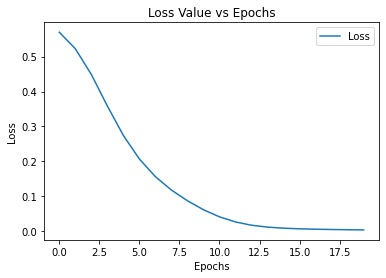

In [ ]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

#Evaluation

In [ ]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    print(y_pred)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

tensor([[-12.3187,   8.3987],
        [-12.3255,   8.3369],
        [-15.0629,  10.2365],
        ...,
        [ -7.3028,   4.8142],
        [ -4.8408,   3.2189],
        [ -8.3201,   5.6186]])
Accuracy : 98.63603973388672%


In [ ]:
torch.max(y_pred, 1)[1].eq(y_test)[-3]

tensor(True)

In [ ]:
y_test

tensor([1, 1, 1,  ..., 1, 1, 1])

#Save the model using torh

In [ ]:
model = LogisticRegression()
torch.save(model,'model.pth')

In [ ]:
print(model.state_dict)

<bound method Module.state_dict of LogisticRegression(
  (linear1): Linear(in_features=6177, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)>


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])